In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules, plot_tree_leafs_for_class
from tasks.adult import make_task_modified_hours_per_week_and_country as make_task
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
clf_a, clf_b, X, X_display, y, feature_names = make_task()

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:06:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:06:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Local explanations

In [4]:
is_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

## $(False, True)$

In [5]:
focus_class = '(False, True)'

In [6]:
instance_indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]
instance_indices

array([2190, 2949, 3925])

In [9]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.test.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/3
2/3
3/3
CPU times: user 29min 50s, sys: 3min 31s, total: 33min 21s
Wall time: 14min 51s


In [7]:
with open(f'diro2c.{focus_class}.test.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [8]:
class_names = explanations[0]['class_names']
feature_names = comparer.feature_names

In [9]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


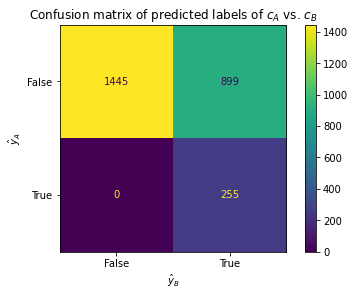

In [10]:
comparer.plot_confusion_matrix(X_explain)

In [11]:
def explain(max_depth=None, tree_fig_size=(28, 14)):
    global tree
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_explain, y_explain)
    
    feature_importances = tree.feature_importances_
    feature_order = np.flip(np.argsort(feature_importances))
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_title('Relative feature importance')
    ax.scatter(np.flip(feature_importances[feature_order]),
               np.flip(comparer.feature_names[feature_order]))
    plt.show()
    
    fig, ax = plt.subplots(figsize=(14, 14))
    plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, node_ids=True, precision=1)
    
    y_test = mclass_diff == np.where(comparer.class_names == focus_class)[0][0]
    print_rules(tree, feature_names, class_names, focus_class, X_test=X, y_test=y_test, precision=1,
                feature_order=feature_order)
    
    plot_tree_leafs_for_class(tree, class_names, focus_class, X, mclass_diff, comparer.class_names,
                              feature_names)
    
    print('\ngenerated data evaluation:')
    print(classification_report(y_explain, tree.predict(X_explain), target_names=class_names))

    print('\noriginal data evaluation:')
    print(classification_report(mclass_diff == np.where(comparer.class_names == focus_class)[0][0],
                                tree.predict(X), target_names=class_names))

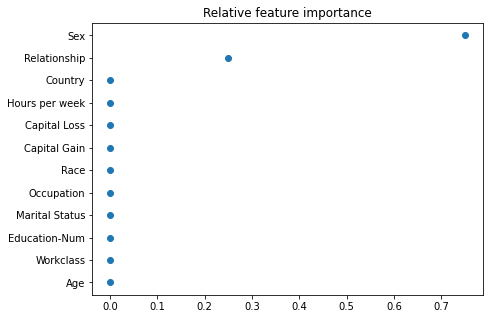

node #6: if (Sex > 0.5) and (Relationship > 3.5) then class (False, True) (covers 0.647 of 1368 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.99      0.72      0.83      1700
    (False, True)       0.65      0.98      0.78       899

         accuracy                           0.81      2599
        macro avg       0.82      0.85      0.81      2599
     weighted avg       0.87      0.81      0.81      2599


original data evaluation:
                   precision    recall  f1-score   support

not (False, True)       1.00      0.60      0.75      6510
    (False, True)       0.00      1.00      0.00         3

         accuracy                           0.60      6513
        macro avg       0.50      0.80      0.38      6513
     weighted avg       1.00      0.60      0.75      6513



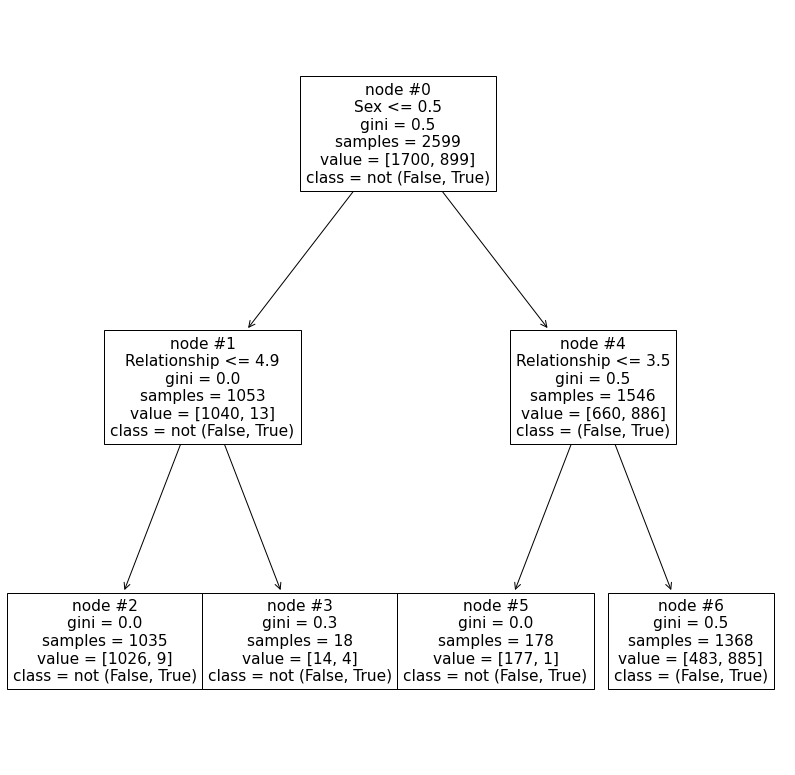

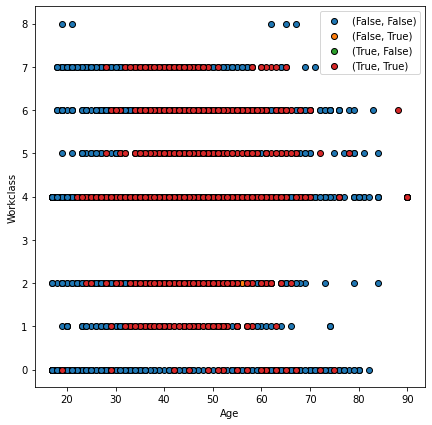

In [12]:
explain(max_depth=2)

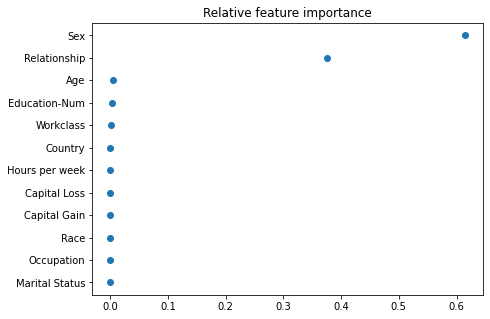

node #13: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.5) then class (False, True) (covers 0.715 of 1225 instances)
node #7: if (Sex <= 0.5) and (Relationship > 4.9) and (Age > 51.5) then class (False, True) (covers 0.667 of 6 instances)
node #11: if (Sex > 0.5) and (Relationship <= 3.5) and (Education-Num > 15.2) then class (False, True) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.99      0.79      0.88      1700
    (False, True)       0.72      0.98      0.83       899

         accuracy                           0.86      2599
        macro avg       0.85      0.89      0.85      2599
     weighted avg       0.89      0.86      0.86      2599


original data evaluation:
                   precision    recall  f1-score   support

not (False, True)       1.00      0.59      0.74      6510
    (False, True)       0.00      1.00      0.00         3

         accuracy     

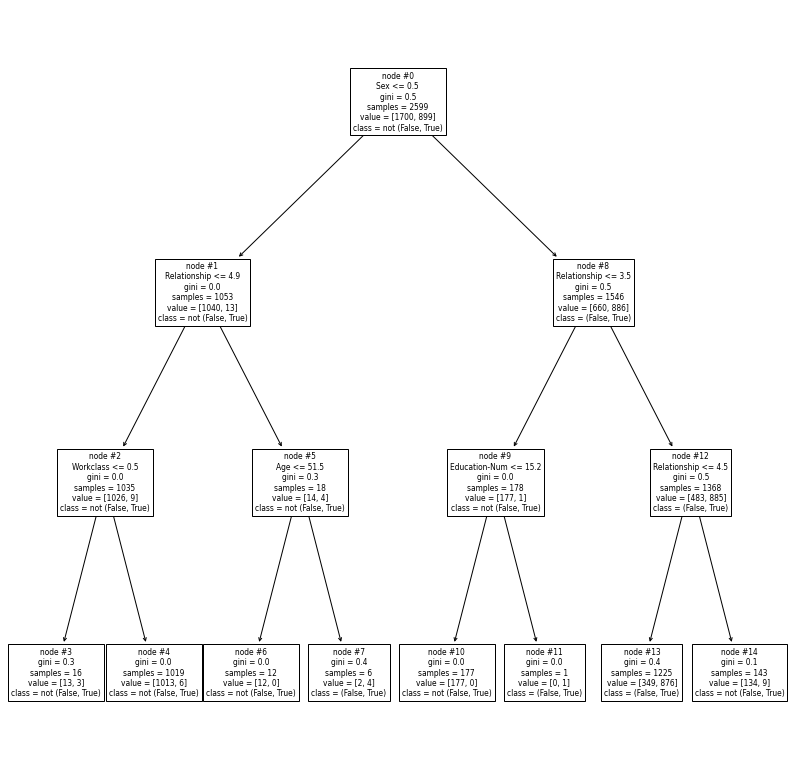

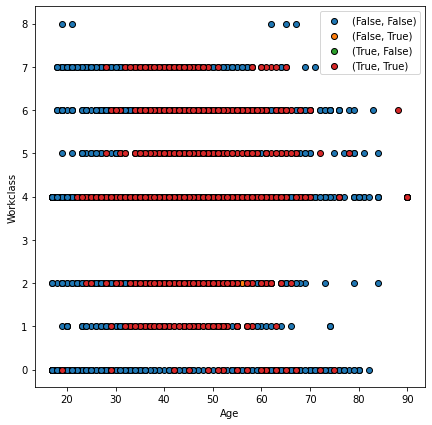

In [13]:
explain(max_depth=3)

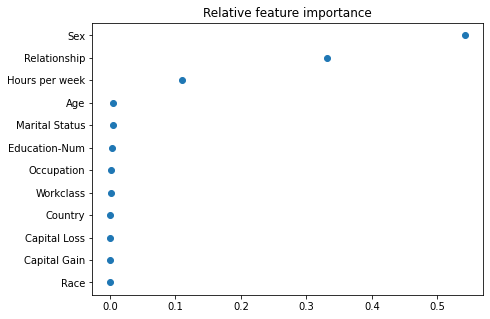

node #21: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.5) and (Hours per week > 40.4) then class (False, True) (covers 0.76 of 1152 instances)
node #12: if (Sex <= 0.5) and (Relationship > 4.9) and (Relationship <= 5.9) and (Age > 51.5) then class (False, True) (covers 0.8 of 5 instances)
node #24: if (Sex > 0.5) and (Relationship > 4.5) and (Marital Status > 3.5) then class (False, True) (covers 0.667 of 3 instances)
node #17: if (Sex > 0.5) and (Relationship <= 3.5) and (Education-Num > 15.2) then class (False, True) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.99      0.84      0.91      1700
    (False, True)       0.76      0.98      0.86       899

         accuracy                           0.89      2599
        macro avg       0.87      0.91      0.88      2599
     weighted avg       0.91      0.89      0.89      2599


original data evaluation:
                 

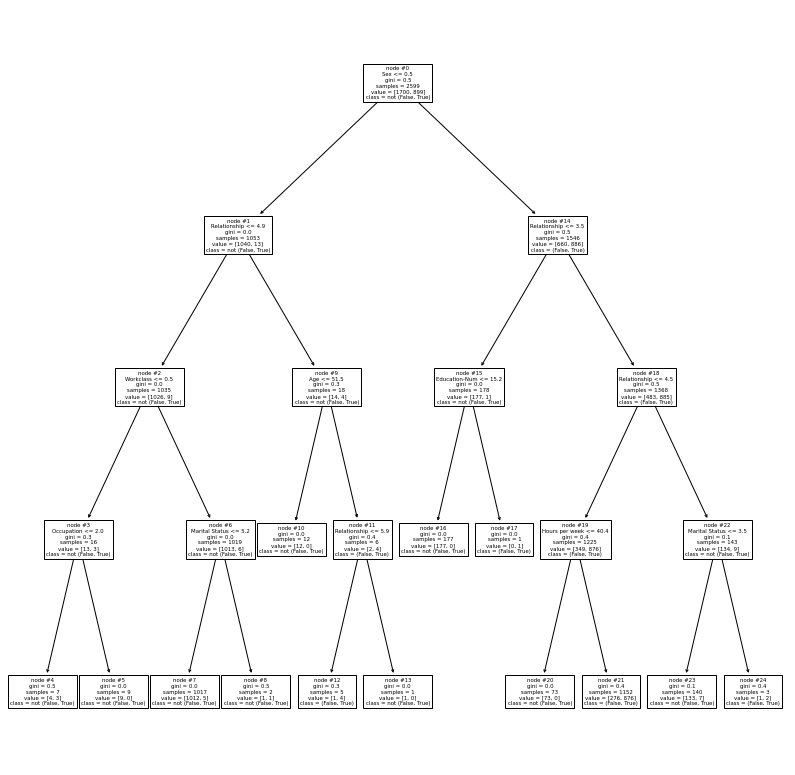

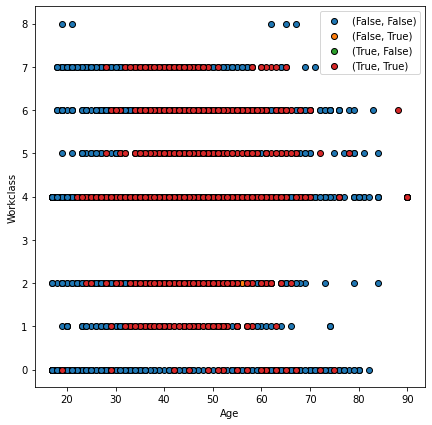

In [14]:
explain(max_depth=4)

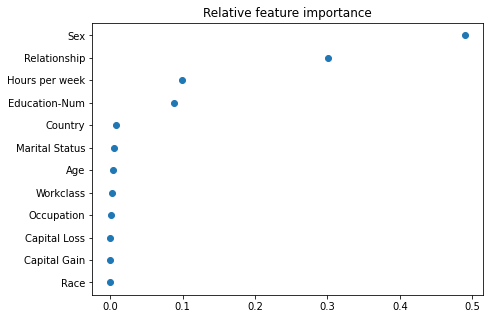

node #31: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.5) and (Hours per week > 40.4) and (Education-Num > 9.5) then class (False, True) (covers 0.799 of 1096 instances)
node #20: if (Sex <= 0.5) and (Relationship > 4.9) and (Relationship <= 5.9) and (Age > 51.5) and (Workclass > 1.5) then class (False, True) (covers 1.0 of 4 instances)
node #6: if (Sex <= 0.5) and (Relationship <= 4.9) and (Country > 35.1) and (Workclass <= 0.5) and (Occupation <= 2.0) then class (False, True) (covers 1.0 of 3 instances)
node #38: if (Sex > 0.5) and (Relationship > 4.5) and (Country > 32.5) and (Marital Status > 3.5) then class (False, True) (covers 1.0 of 2 instances)
node #13: if (Sex <= 0.5) and (Relationship <= 4.9) and (Marital Status > 5.2) and (Marital Status <= 5.7) and (Workclass > 0.5) then class (False, True) (covers 1.0 of 1 instances)
node #25: if (Sex > 0.5) and (Relationship <= 3.5) and (Education-Num > 15.2) then class (False, True) (covers 1.0 of 1 instances)
node #3

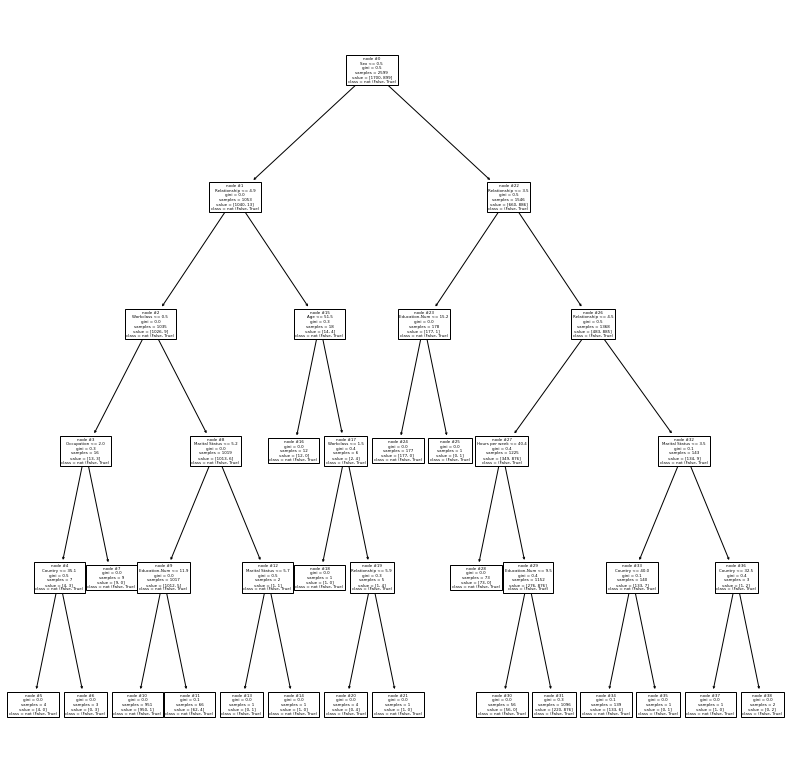

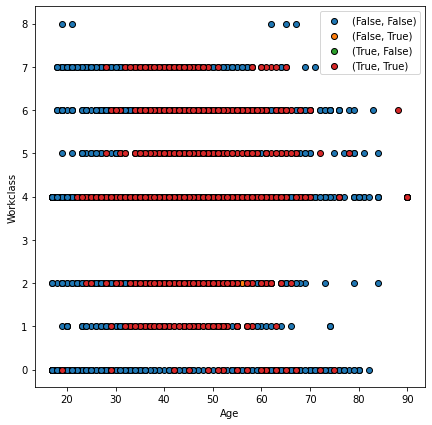

In [15]:
explain(max_depth=5)

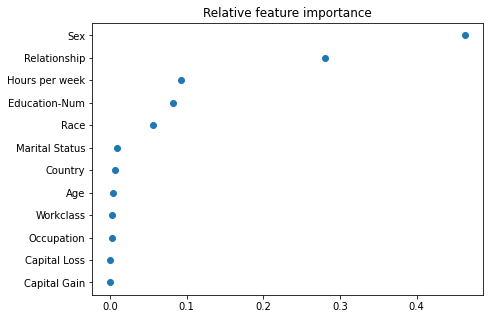

node #37: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.5) and (Hours per week > 40.4) and (Education-Num > 9.5) and (Race > 3.4) then class (False, True) (covers 0.828 of 1057 instances)
node #24: if (Sex <= 0.5) and (Relationship > 4.9) and (Age > 51.5) and (Workclass > 1.5) and (Occupation <= 5.5) then class (False, True) (covers 1.0 of 4 instances)
node #15: if (Sex <= 0.5) and (Relationship <= 4.9) and (Education-Num > 11.9) and (Marital Status > 2.1) and (Marital Status <= 5.2) and (Workclass > 0.5) then class (False, True) (covers 0.75 of 4 instances)
node #6: if (Sex <= 0.5) and (Relationship <= 4.9) and (Country > 35.1) and (Workclass <= 0.5) and (Occupation <= 2.0) then class (False, True) (covers 1.0 of 3 instances)
node #46: if (Sex > 0.9) and (Relationship > 4.5) and (Marital Status > 3.5) then class (False, True) (covers 1.0 of 2 instances)
node #17: if (Sex <= 0.2) and (Relationship <= 4.9) and (Marital Status > 5.2) and (Workclass > 0.5) then class (Fal

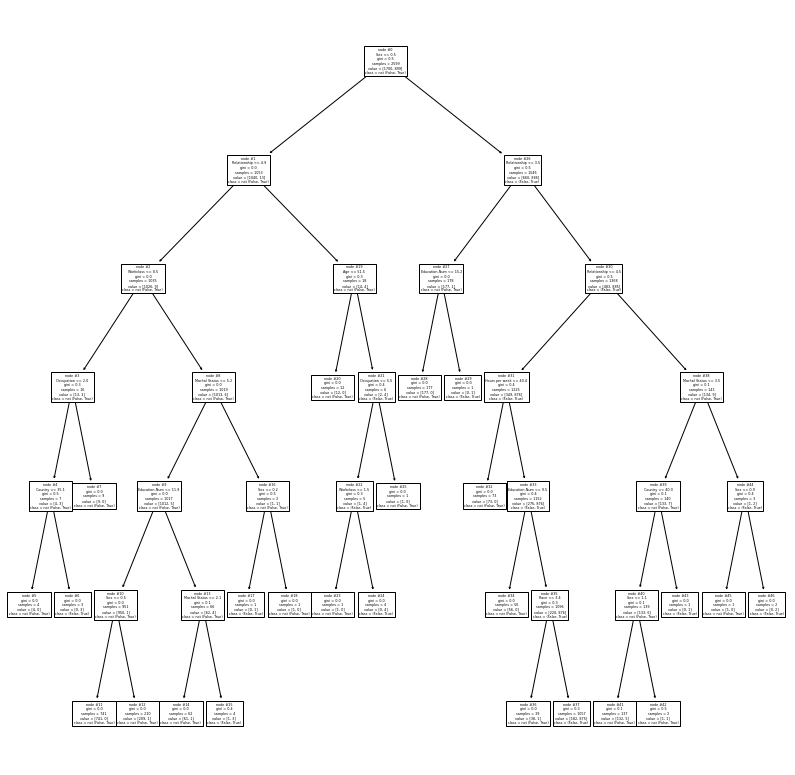

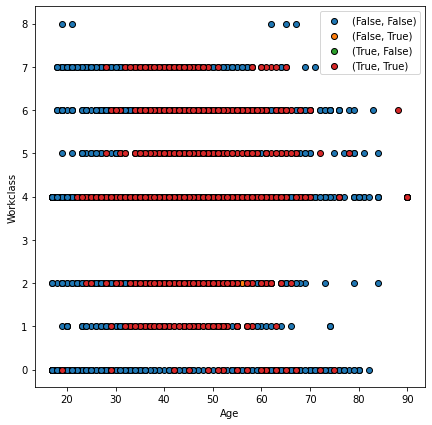

In [16]:
explain(max_depth=6)

- Sex is more important than Relationship
- Race and Occupation are of importance now, instead of Marital Status
- Limits of features present in old and new rule are identical for Sex, Relationship, Race, Education-Num. Hours per week differs by 0.3

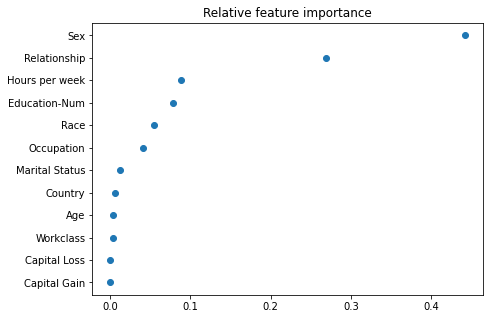

node #46: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.5) and (Hours per week > 40.4) and (Education-Num > 9.5) and (Race > 3.4) and (Occupation <= 4.1) then class (False, True) (covers 0.849 of 1030 instances)
node #30: if (Sex <= 0.5) and (Relationship > 4.9) and (Occupation <= 5.5) and (Age > 51.5) and (Workclass > 1.5) then class (False, True) (covers 1.0 of 4 instances)
node #20: if (Sex <= 0.5) and (Relationship <= 4.9) and (Education-Num > 11.9) and (Marital Status > 2.1) and (Marital Status <= 4.5) and (Workclass > 0.5) then class (False, True) (covers 1.0 of 3 instances)
node #6: if (Sex <= 0.5) and (Relationship <= 4.9) and (Occupation <= 2.0) and (Country > 35.1) and (Workclass <= 0.5) then class (False, True) (covers 1.0 of 3 instances)
node #59: if (Sex > 0.5) and (Relationship > 4.5) and (Marital Status > 3.5) and (Marital Status <= 4.8) then class (False, True) (covers 1.0 of 2 instances)
node #23: if (Sex <= 0.5) and (Relationship <= 4.9) and (Marital 

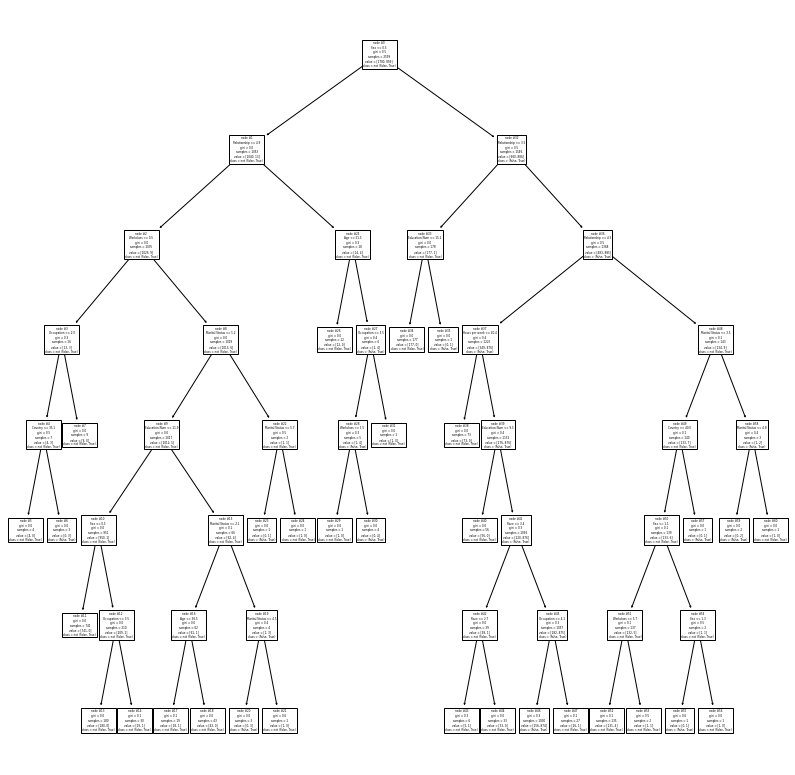

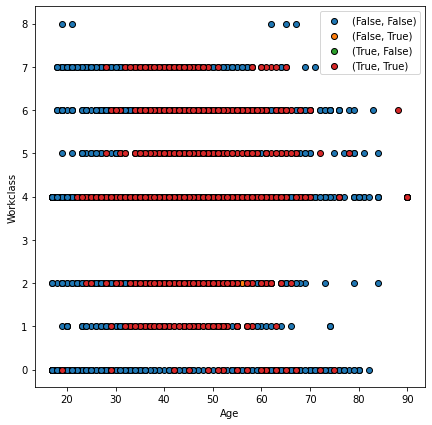

In [17]:
explain(max_depth=7)

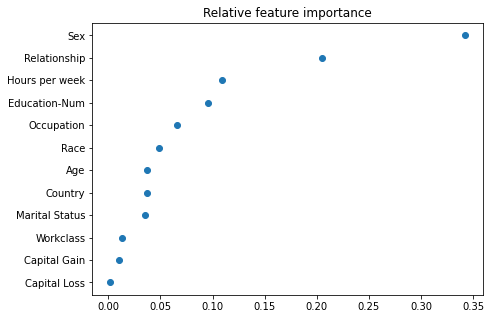

node #97: if (Sex > 0.5) and (Sex <= 1.0) and (Relationship > 3.5) and (Relationship <= 4.5) and (Hours per week > 44.5) and (Hours per week <= 48.4) and (Education-Num > 10.5) and (Education-Num <= 12.5) and (Occupation > 3.8) and (Occupation <= 4.1) and (Race > 3.4) and (Age > 29.4) and (Age <= 36.0) and (Marital Status <= 2.6) and (Workclass > 1.3) and (Workclass <= 5.7) and (Capital Gain <= 976.2) then class (False, True) (covers 1.0 of 266 instances)
node #77: if (Sex > 0.5) and (Sex <= 1.0) and (Relationship > 3.5) and (Relationship <= 4.5) and (Hours per week > 40.4) and (Hours per week <= 41.7) and (Education-Num > 9.5) and (Education-Num <= 12.5) and (Occupation > 0.9) and (Occupation <= 3.5) and (Race > 3.4) and (Age > 38.9) and (Age <= 61.4) and (Marital Status <= 2.6) and (Workclass > 1.3) and (Workclass <= 5.7) and (Capital Gain <= 976.2) and (Capital Loss <= 801.0) then class (False, True) (covers 1.0 of 223 instances)
node #104: if (Sex > 1.0) and (Relationship > 3.5) an

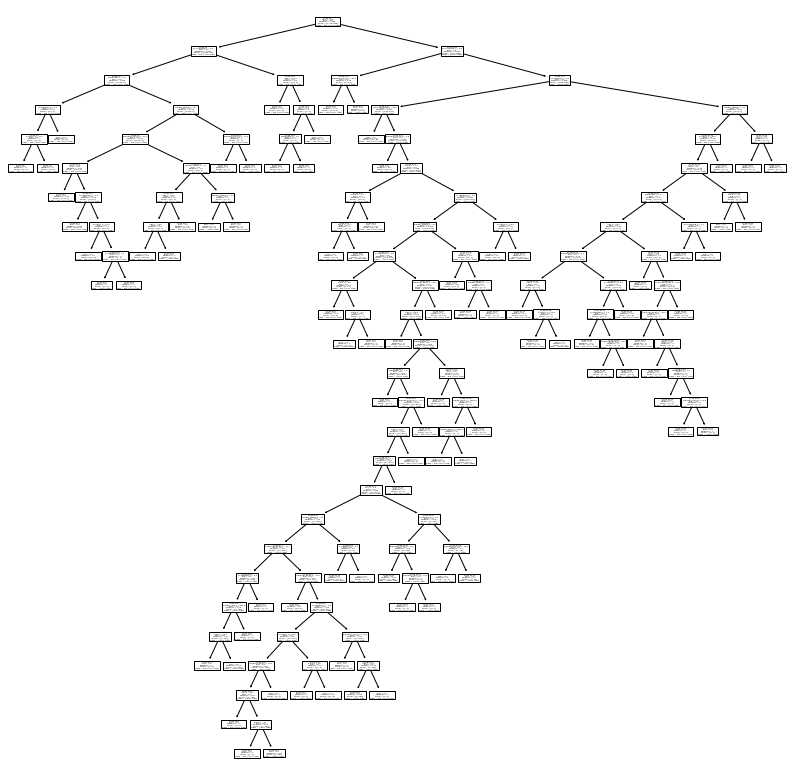

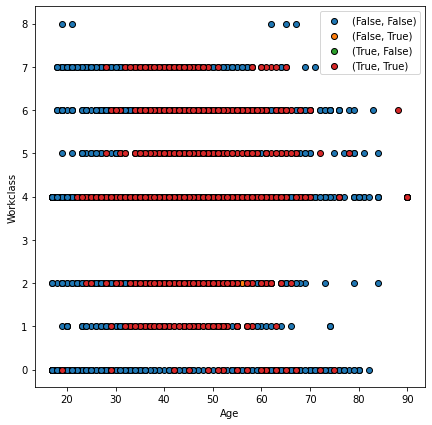

In [18]:
explain()

Not even the fully expanded tree explains the three instances (0% precision on original data set)

## $(True, False)$

In [19]:
focus_class = '(True, False)'

In [20]:
instance_indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]
instance_indices

array([5992])

In [21]:
comparer.predict_mclass_diff_proba(X[instance_indices, :])

array([[0.24376692, 0.24279086, 0.2572361 , 0.25620613]], dtype=float32)

In [22]:
pd.DataFrame(X[instance_indices], columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,35.0,4.0,13.0,2.0,5.0,4.0,4.0,1.0,0.0,0.0,65.0,41.0


In [28]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.test.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/1
CPU times: user 10min 33s, sys: 1min 4s, total: 11min 38s
Wall time: 4min 34s


In [23]:
with open(f'diro2c.{focus_class}.test.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [24]:
class_names = explanations[0]['class_names']
feature_names = comparer.feature_names

In [25]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


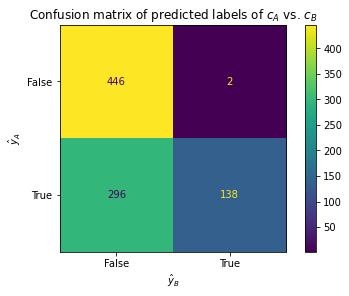

In [26]:
comparer.plot_confusion_matrix(X_explain)

In [27]:
mask = comparer.class_names[comparer.predict_mclass_diff(X_explain)] == focus_class
pd.DataFrame(X_explain[mask], columns=feature_names)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,27.10468,4.0,13.0,2.000000,10.0,4.000000,3.916047,1.0,0.000000,0.0,65.0,41.0
1,34.00000,4.0,13.0,1.784286,5.0,4.000000,4.000000,1.0,0.000000,0.0,65.0,41.0
2,34.00000,4.0,13.0,2.000000,5.0,3.819266,4.000000,1.0,0.000000,0.0,65.0,41.0
3,34.00000,4.0,13.0,2.000000,5.0,4.000000,3.026378,1.0,0.000000,0.0,65.0,41.0
4,34.00000,4.0,13.0,2.000000,5.0,4.000000,3.610937,1.0,0.000000,0.0,65.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
291,36.00000,4.0,13.0,2.000000,5.0,4.000000,1.711866,1.0,0.000000,0.0,65.0,41.0
292,50.00000,4.0,13.0,2.000000,7.0,4.000000,4.000000,0.0,0.000000,0.0,65.0,41.0
293,52.00000,4.0,13.0,2.000000,14.0,4.000000,4.000000,0.0,0.000000,0.0,65.0,41.0
294,60.65335,4.0,13.0,2.000000,5.0,4.000000,4.006001,1.0,-5409.857581,0.0,65.0,41.0


In [28]:
# Check for errors
is_explain_diff = explainer.clf_a.predict(X_explain) != explainer.clf_b.predict(X_explain)
(is_explain_diff != y_explain).sum(), len(y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(0, 882)

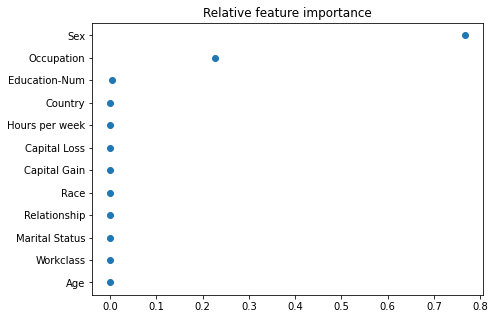

node #6: if (Sex > 0.5) and (Occupation > 4.4) then class (True, False) (covers 0.696 of 421 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (True, False)       0.99      0.78      0.87       586
    (True, False)       0.70      0.99      0.82       296

         accuracy                           0.85       882
        macro avg       0.84      0.89      0.85       882
     weighted avg       0.89      0.85      0.86       882


original data evaluation:
                   precision    recall  f1-score   support

not (True, False)       1.00      0.62      0.76      6512
    (True, False)       0.00      1.00      0.00         1

         accuracy                           0.62      6513
        macro avg       0.50      0.81      0.38      6513
     weighted avg       1.00      0.62      0.76      6513



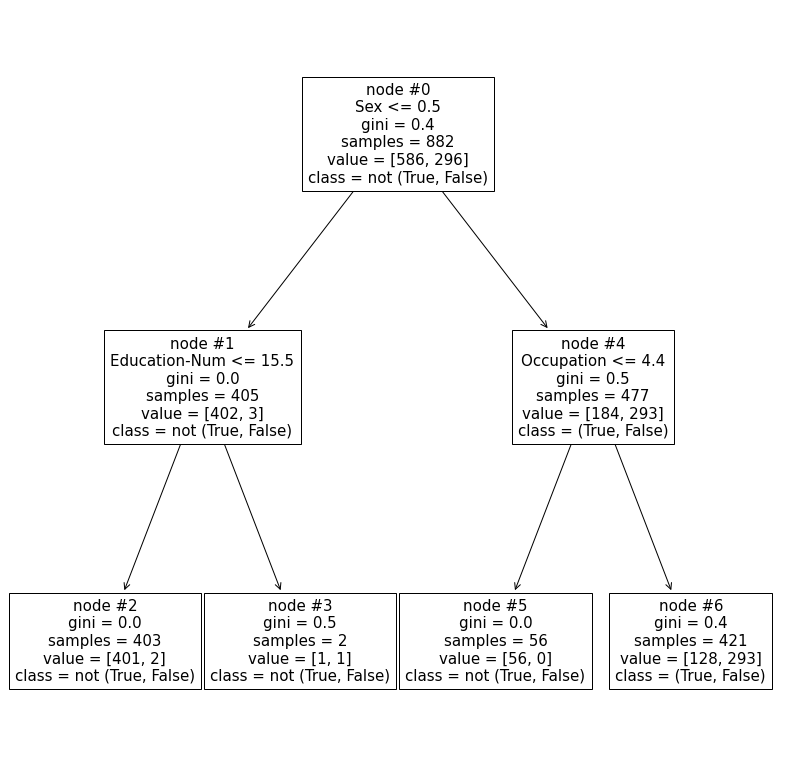

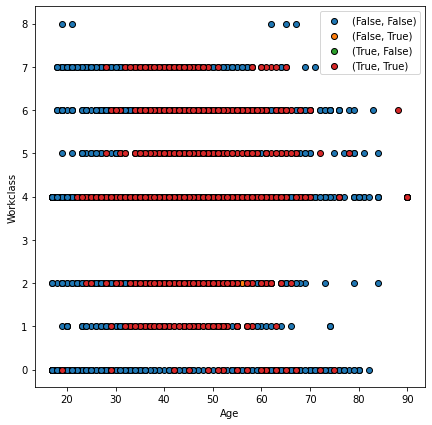

In [29]:
explain(max_depth=2)

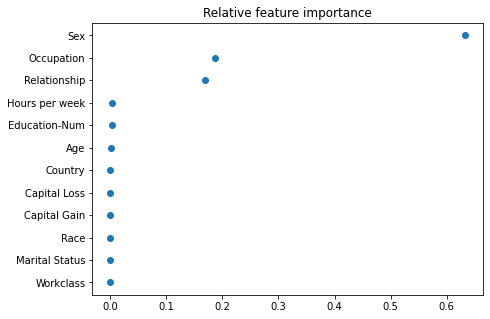

node #12: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) then class (True, False) (covers 0.772 of 378 instances)
node #7: if (Sex <= 0.5) and (Hours per week > 52.5) and (Education-Num > 15.5) then class (True, False) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (True, False)       0.99      0.85      0.92       586
    (True, False)       0.77      0.99      0.87       296

         accuracy                           0.90       882
        macro avg       0.88      0.92      0.89       882
     weighted avg       0.92      0.90      0.90       882


original data evaluation:
                   precision    recall  f1-score   support

not (True, False)       1.00      0.78      0.88      6512
    (True, False)       0.00      1.00      0.00         1

         accuracy                           0.78      6513
        macro avg       0.50      0.89      0.44      6513
     weighted avg       1.00

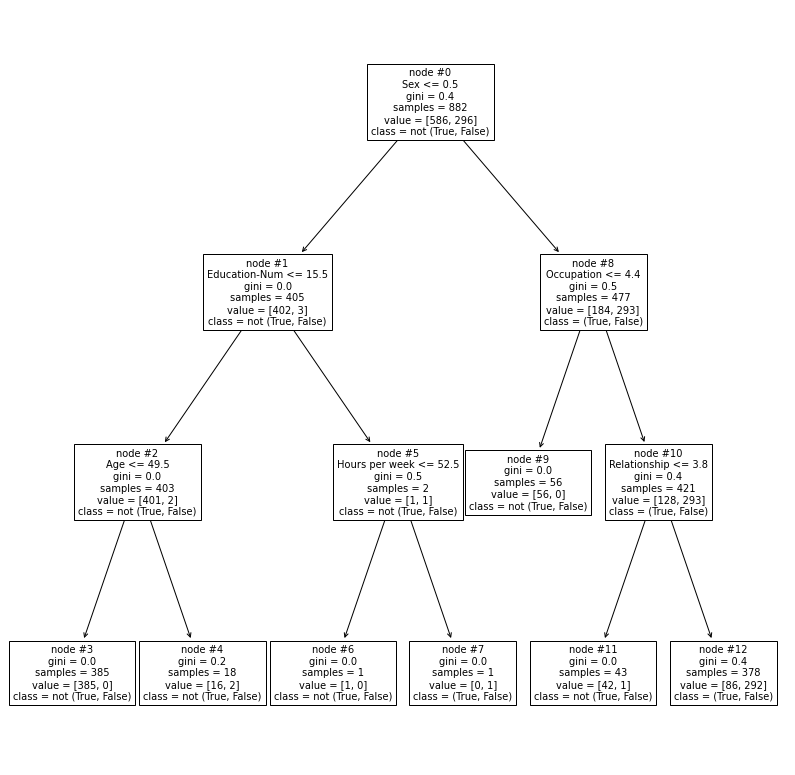

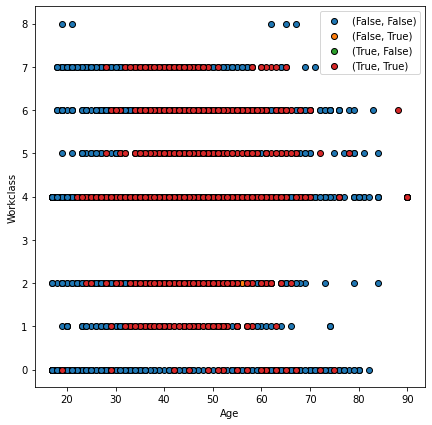

In [30]:
explain(max_depth=3)

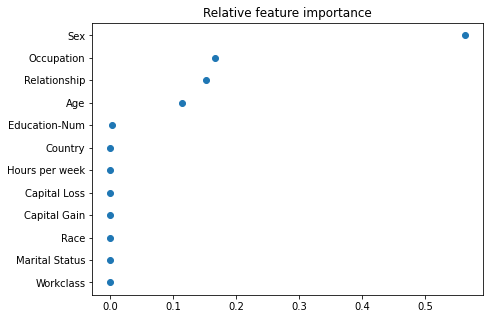

node #17: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) and (Age <= 35.7) then class (True, False) (covers 0.833 of 347 instances)
node #8: if (Sex <= 0.2) and (Education-Num > 15.5) then class (True, False) (covers 1.0 of 1 instances)
node #5: if (Sex <= 0.5) and (Age > 49.5) and (Age <= 50.2) and (Education-Num <= 15.5) then class (True, False) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (True, False)       0.99      0.90      0.94       586
    (True, False)       0.83      0.98      0.90       296

         accuracy                           0.93       882
        macro avg       0.91      0.94      0.92       882
     weighted avg       0.94      0.93      0.93       882


original data evaluation:
                   precision    recall  f1-score   support

not (True, False)       1.00      0.93      0.96      6512
    (True, False)       0.00      1.00      0.00         1

         accura

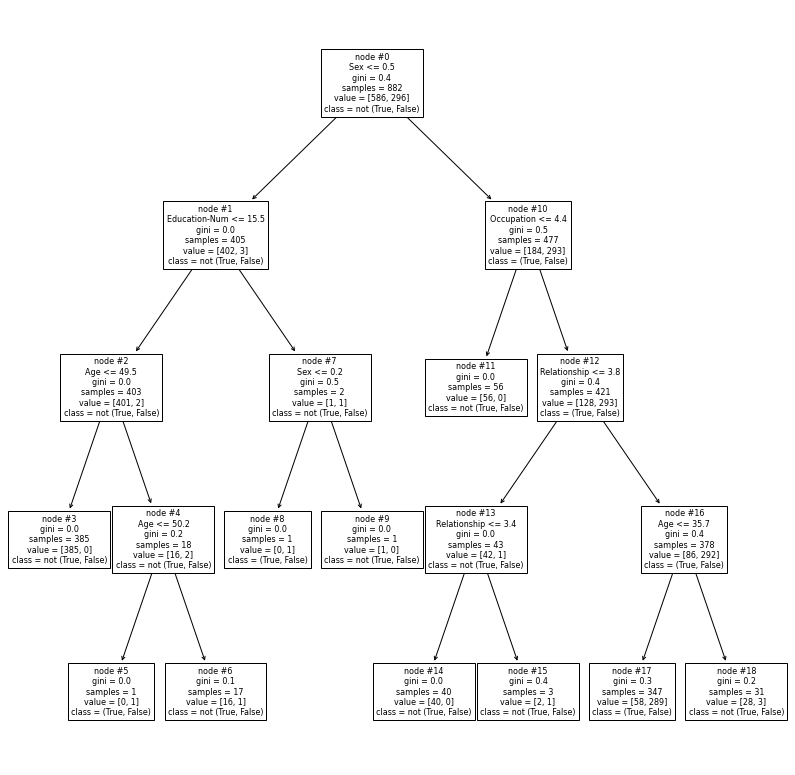

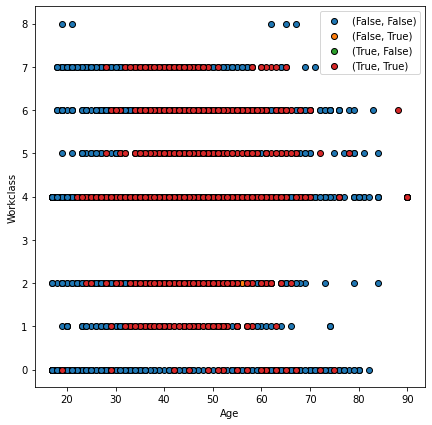

In [31]:
explain(max_depth=4)

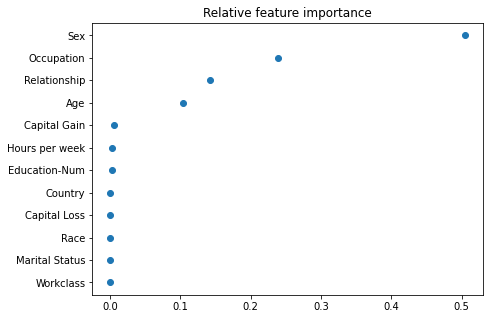

node #22: if (Sex > 0.5) and (Occupation > 4.4) and (Occupation <= 5.3) and (Relationship > 3.8) and (Age <= 35.7) then class (True, False) (covers 0.883 of 326 instances)
node #25: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) and (Age > 35.7) and (Capital Gain <= -3752.0) then class (True, False) (covers 1.0 of 1 instances)
node #18: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.4) and (Relationship <= 3.7) then class (True, False) (covers 1.0 of 1 instances)
node #11: if (Sex <= 0.5) and (Hours per week > 52.5) and (Education-Num > 15.5) then class (True, False) (covers 1.0 of 1 instances)
node #5: if (Sex <= 0.5) and (Age > 49.5) and (Age <= 50.2) and (Education-Num <= 15.5) then class (True, False) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (True, False)       0.99      0.94      0.96       586
    (True, False)       0.88      0.99      0.93       296

         accuracy    

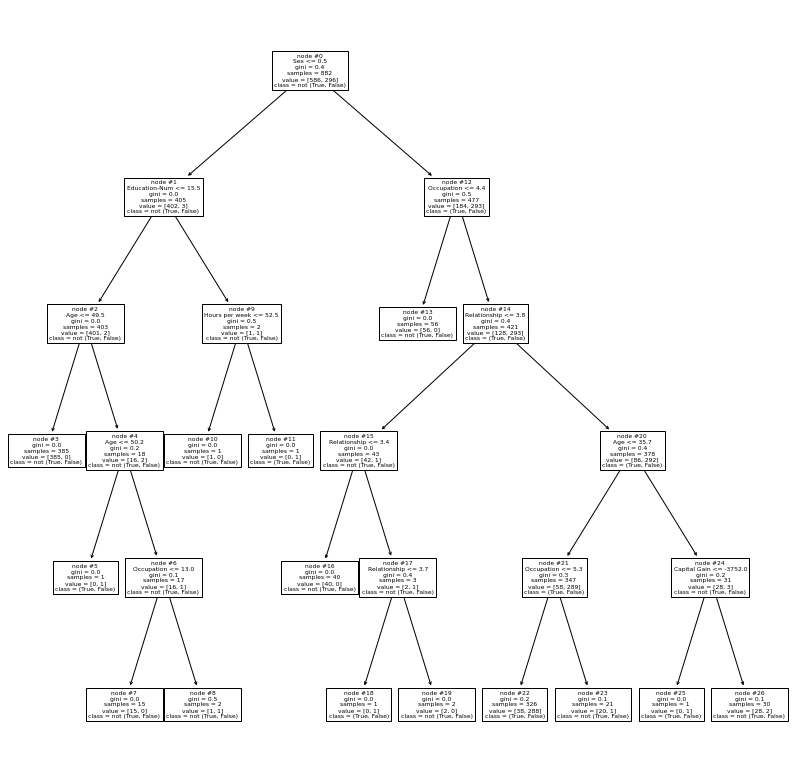

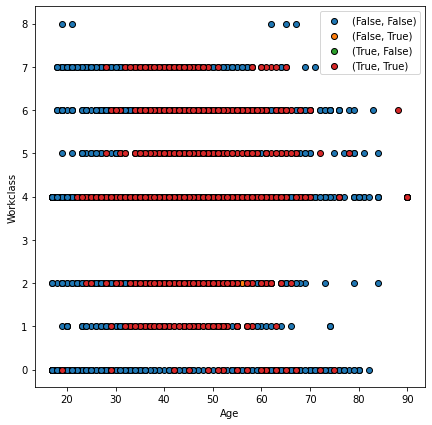

In [32]:
explain(max_depth=5)

- Age is now of importance instead of Marital Status
- Sex is now of even higher importance than previously
- Categorical feature terms Sex, Occupation, Education-Num, Relationship are equal. However, 

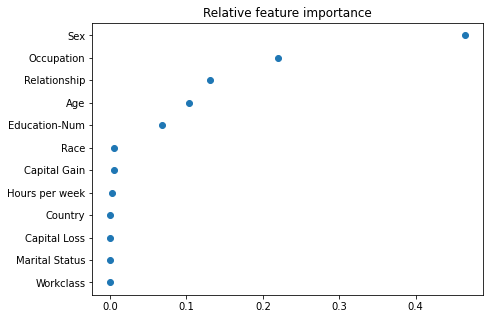

node #26: if (Sex > 0.5) and (Occupation > 4.4) and (Occupation <= 5.3) and (Relationship > 3.8) and (Age <= 35.7) and (Education-Num > 12.7) then class (True, False) (covers 0.923 of 312 instances)
node #28: if (Sex > 0.5) and (Occupation > 5.3) and (Relationship > 3.8) and (Age <= 28.1) then class (True, False) (covers 1.0 of 1 instances)
node #20: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.4) and (Relationship <= 3.7) then class (True, False) (covers 1.0 of 1 instances)
node #33: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) and (Age > 35.7) and (Race <= 2.8) and (Capital Gain > -3752.0) then class (True, False) (covers 1.0 of 1 instances)
node #31: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) and (Age > 35.7) and (Capital Gain <= -3752.0) then class (True, False) (covers 1.0 of 1 instances)
node #13: if (Sex <= 0.5) and (Education-Num > 15.5) and (Hours per week > 52.5) then class (True, False) (covers 1.0 of 1 instances)
node #9:

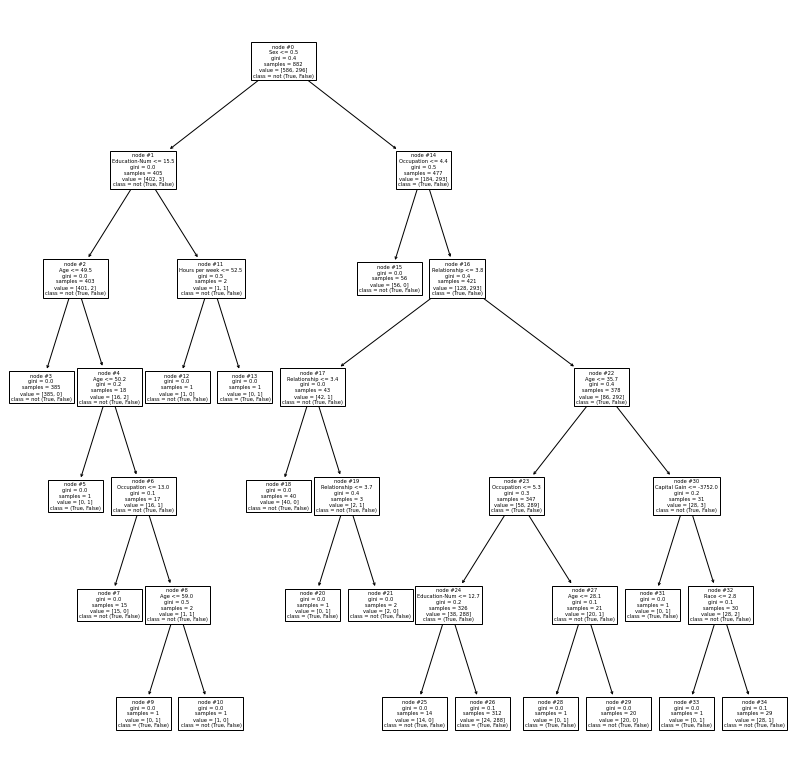

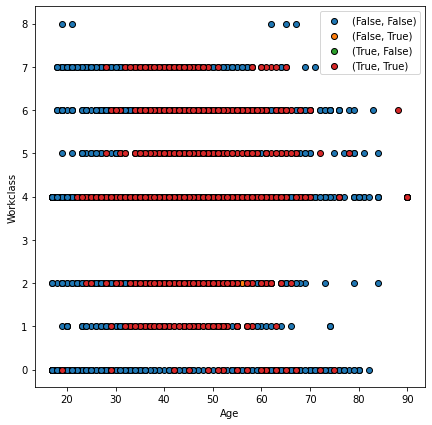

In [33]:
explain(max_depth=6)

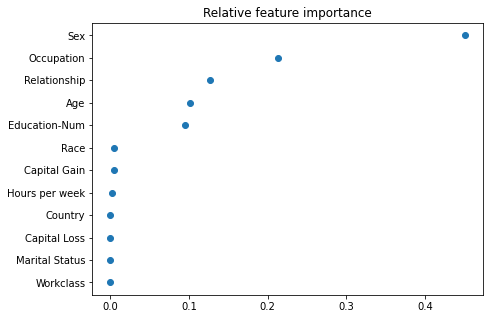

node #27: if (Sex > 0.5) and (Occupation > 4.4) and (Occupation <= 5.3) and (Relationship > 3.8) and (Age <= 35.7) and (Education-Num > 12.7) and (Education-Num <= 13.5) then class (True, False) (covers 0.941 of 306 instances)
node #30: if (Sex > 0.5) and (Occupation > 5.3) and (Relationship > 3.8) and (Age <= 28.1) then class (True, False) (covers 1.0 of 1 instances)
node #33: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) and (Age > 35.7) and (Capital Gain <= -3752.0) then class (True, False) (covers 1.0 of 1 instances)
node #13: if (Sex <= 0.5) and (Education-Num > 15.5) and (Hours per week > 52.5) then class (True, False) (covers 1.0 of 1 instances)
node #9: if (Sex <= 0.5) and (Occupation > 13.0) and (Age > 50.2) and (Age <= 59.0) and (Education-Num <= 15.5) then class (True, False) (covers 1.0 of 1 instances)
node #35: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) and (Age > 35.7) and (Race <= 2.8) and (Capital Gain > -3752.0) then class (True, Fa

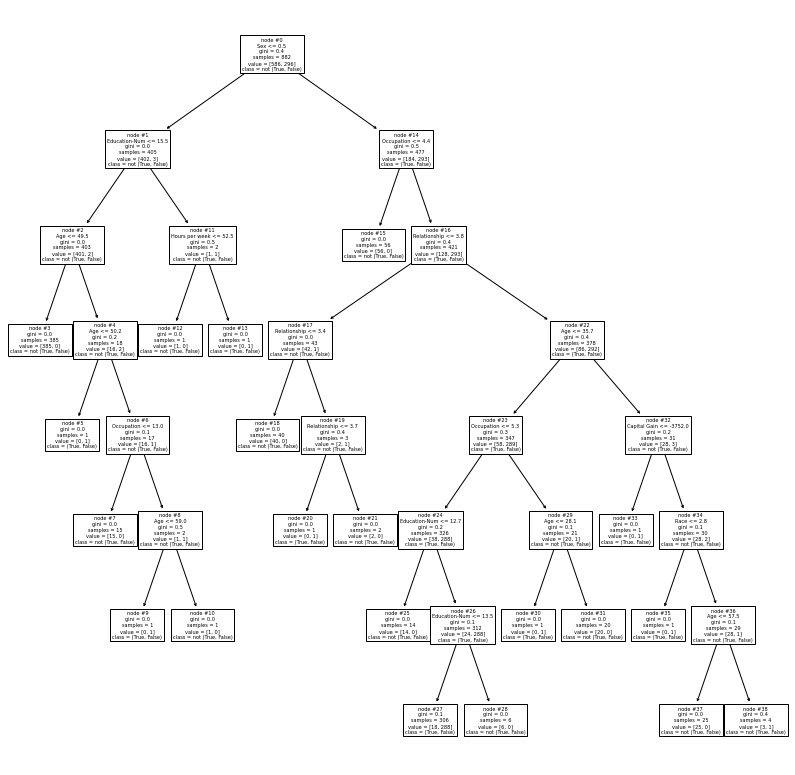

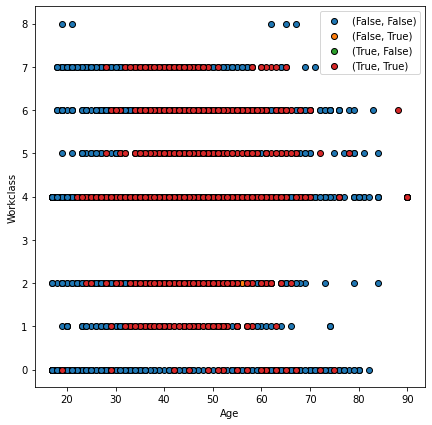

In [34]:
explain(max_depth=7)

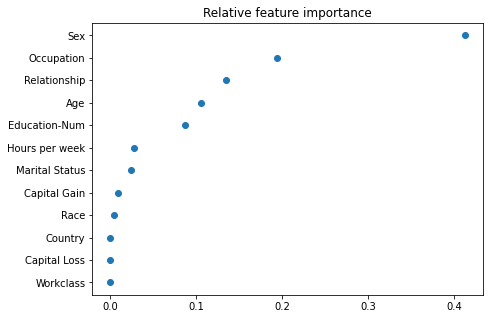

node #34: if (Sex > 0.5) and (Occupation > 4.4) and (Occupation <= 5.3) and (Relationship > 3.8) and (Relationship <= 4.5) and (Age > 33.7) and (Age <= 35.7) and (Education-Num > 12.7) and (Education-Num <= 13.5) and (Hours per week > 57.5) and (Marital Status <= 2.6) and (Capital Gain <= 3685.5) then class (True, False) (covers 1.0 of 288 instances)
node #49: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) and (Age > 57.5) and (Age <= 69.0) and (Capital Gain > -3752.0) and (Race > 2.8) then class (True, False) (covers 1.0 of 1 instances)
node #20: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.4) and (Relationship <= 3.7) then class (True, False) (covers 1.0 of 1 instances)
node #43: if (Sex > 0.5) and (Occupation > 4.4) and (Relationship > 3.8) and (Age > 35.7) and (Race <= 2.8) then class (True, False) (covers 1.0 of 1 instances)
node #12: if (Sex <= 0.2) and (Education-Num > 15.5) then class (True, False) (covers 1.0 of 1 instances)
node #9: if (Sex <= 0

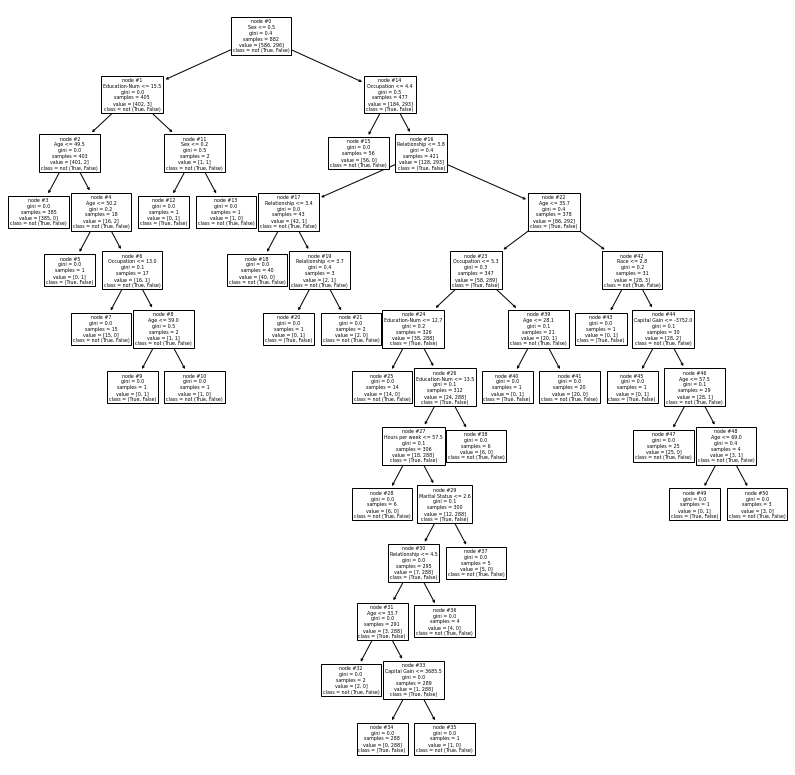

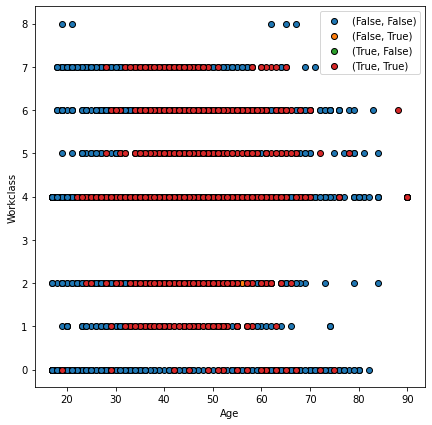

In [35]:
explain()

Again, precision of the target class is 0 on the original data set.